In [4]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.integrate import quad 
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import display
# import ipywidgets as widgets
import os
# from ipywidgets import interact, IntSlider, Button, VBox, Output
import numpy.polynomial.polynomial as poly
from scipy import constants as const


In [5]:
# Leer el archivo CSV con separador y decimal correctos
df = pd.read_csv('Alfa_Boo_pepsi.csv', delim_whitespace=True)

wavelength = df['Wavelength'].values

flux = df['Normalised_Flux'].values

C:\Users\Jessi Dani\AppData\Local\Temp\ipykernel_18928\1875966600.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('Alfa_Boo_pepsi.csv', delim_whitespace=True)


In [6]:
df_hierro = pd.read_excel('lista de lineas Arcturus.xlsx', header=7, usecols=['l aire', 'l aire m'])

fe_1_lineas = df_hierro['l aire']
fe_1_lineas = fe_1_lineas.dropna().values

fe_1_lineas_mezclas = df_hierro['l aire m']
fe_1_lineas_mezclas = fe_1_lineas_mezclas.dropna().values

len(fe_1_lineas_mezclas)

338

In [7]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda
    closer_data = closer_data[closer_data['abs'] <= 0.01].reset_index(drop=True)

    return closer_data.drop(['abs'],axis=1)

#Closer lines
closer_lines = find_minimums(wavelength, flux ,fe_1_lineas_mezclas)

closer_lines

,min_wave,min_flux,Fe line
0,3941.274184,0.462236,3941.2753
1,3946.997441,0.239609,3946.9949
2,3948.098023,0.181945,3948.0973
3,4000.460484,0.138299,4000.4572
4,4001.667965,0.111566,4001.6617
...,...,...,...
258,8804.630241,0.493822,8804.6258
259,8838.421982,0.388838,8838.4290
260,9024.360841,0.688184,9024.3691
261,9103.636586,0.824618,9103.6375


In [8]:
def width_minimums(closer_lines, wave, flux, width):
    local_points = []
    for each in closer_lines['min_wave']:
        mask = (wave > each - width) & (wave < each + width)
        local_points.append(pd.DataFrame({
            'Wave': wave[mask],
            'Flux': flux[mask]
        }))
    return local_points

local_points = width_minimums(closer_lines, wavelength, flux, width=0.05)

len(local_points)

263

Filtro usando la segunda derivada

In [9]:
def Fit_derivates(local_points,closer_lines):
    values = []
    fit = []
    local = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave'], local_points[i]['Flux'] #The index i correspond at one line in the lambda_list of lines 

        #Internal rise, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second

        flux_fit = poly.polyval(wave_scaled,param) #Evaluate the fit

        #First condition: The parameter of the order two polynomium need to be positive.
        #Second condition (for eliminate lineal terms): The distance between the initial and the final point need to be less than the half of depth
        #In other words, the final point need to be higher than the half of the distance between extreme points

        if d2_param[0]>0 and (data_flux.iloc[-1])>=(np.abs(data_flux.iloc[0]-data_flux.iloc[-1])/2):

            values.append(pd.DataFrame([[closer_lines['Fe line'].iloc[i],closer_lines['min_wave'].iloc[i],closer_lines['min_flux'].iloc[i]]])) 
            fit.append(flux_fit)
            local.append(local_points[i])

    Values = pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Line Fe I",'min_wave','min_flux']

    return Values,fit,local

Values,fit,local = Fit_derivates(local_points,closer_lines)

Values

,Line Fe I,min_wave,min_flux
0,3941.2753,3941.274184,0.462236
1,3946.9949,3946.997441,0.239609
2,3948.0973,3948.098023,0.181945
3,4000.4572,4000.460484,0.138299
4,4001.6617,4001.667965,0.111566
...,...,...,...
258,8804.6258,8804.630241,0.493822
259,8838.4290,8838.421982,0.388838
260,9024.3691,9024.360841,0.688184
261,9103.6375,9103.636586,0.824618


In [10]:
# Values.to_excel('valores_prueba.xlsx',index=False)

In [11]:

# import tkinter as tk
# from tkinter import ttk
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
# import numpy as np

# class OutlierViewer:
#     def __init__(self, root, local_points, values,fit):
#         self.root = root
#         self.root.title("Visualizador de las líneas de Hierro I")
#         self.local_points = local_points
#         self.values = values
#         self.fit = fit
#         self.index = values.index.values
#         self.current_index = 0
    
#         self.setup_ui()
#         self.update_plot()

#     def setup_ui(self):
#         main_frame = ttk.Frame(self.root, padding="10")
#         main_frame.pack(fill=tk.BOTH, expand=True)
    
#         control_frame = ttk.Frame(main_frame)
#         control_frame.pack(fill=tk.X, pady=10)
    
#         ttk.Label(control_frame, text="Índice de la línea:").pack(side=tk.LEFT, padx=5)
#         self.slider = ttk.Scale(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             orient=tk.HORIZONTAL,
#             command=self.on_slider_move
#         )
#         self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
    
#         self.spinbox = ttk.Spinbox(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             width=5,
#             command=self.on_spinbox_change
#         )
#         self.spinbox.pack(side=tk.LEFT, padx=5)
#         self.spinbox.bind("<Return>", self.on_spinbox_change)
    
#         nav_frame = ttk.Frame(control_frame)
#         nav_frame.pack(side=tk.LEFT, padx=10)
    
#         ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
#         ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
    
#         graph_frame = ttk.Frame(main_frame)
#         graph_frame.pack(fill=tk.BOTH, expand=True)
    
#         self.fig, self.ax = plt.subplots(figsize=(10, 6))
#         self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
#         self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    
#         self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
#         self.toolbar.update()
#         self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)

#     def on_slider_move(self, event=None):
#         self.current_index = int(float(self.slider.get()))
#         self.spinbox.delete(0, tk.END)
#         self.spinbox.insert(0, str(self.current_index))
#         self.update_plot()

#     def on_spinbox_change(self, event=None):
#         try:
#             new_index = int(self.spinbox.get())
#             if 0 <= new_index < len(self.index):
#                 self.current_index = new_index
#                 self.slider.set(self.current_index)
#                 self.update_plot()
#         except ValueError:
#             pass

#     def prev_plot(self):
#         if self.current_index > 0:
#             self.current_index -= 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()

#     def next_plot(self):
#         if self.current_index < len(self.index)-1:
#             self.current_index += 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()

#     #Graficas
#     def update_plot(self):
#         j = self.current_index
#         self.ax.clear()
    
#         # Gráfica principal
#         self.ax.plot(
#             self.local_points[j]['Wave'],
#             self.local_points[j]['Flux'],
#             color='pink',
#             label='Spectrum'
#         )
    
#         #Closer lines
#         self.ax.plot(
#             self.local_points[j]['Wave'],
#             self.fit[j],
#             color='purple',
#             label='Fit',
#             marker='.',
#         )
    
#         #Fe I line
#         self.ax.scatter(
#             self.values["Line Fe I"][j],
#             self.values['min_flux'][j],
#             color='red',
#             label='Fe I',
#             s=100
#         )

#         #Fe I line
#         self.ax.scatter(
#             self.values['min_wave'][j],
#             self.values["min_flux"][j],
#             color='purple',
#             s=100
#         )
    
#         #Vainitas del gráfico
#         self.ax.set_title(f'Visualizador - Índice {self.index[j]} - Longitud de onda {self.values["Line Fe I"][j]} Å')
#         self.ax.set_xlabel(r'Wavelength $(\mathring{A})$')
#         self.ax.set_ylabel('Flux')
#         self.ax.legend()
#         self.ax.grid(True)
    
#         self.canvas.draw()


# if __name__ == "__main__":
#     root = tk.Tk()
#     root.geometry("900x700")


#     app = OutlierViewer(root, local, Values,fit)

#     root.mainloop()



In [12]:
df_hierro_revisar = pd.read_excel('linea_mezclas_despues_filtro.xlsx', header=2, usecols=['l aire m'])
fe_1_lineas_mezclas_r = df_hierro_revisar['l aire m']
fe_1_lineas_mezclas_r = fe_1_lineas_mezclas_r.dropna().values

len(fe_1_lineas_mezclas_r)

330

In [13]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)


closer_lines_r = find_minimums(wavelength, flux ,fe_1_lineas_mezclas_r)

closer_lines_r

,min_wave,min_flux,Fe line
0,3941.274184,0.462236,3941.2753
1,3946.997441,0.239609,3946.9949
2,3948.098023,0.181945,3948.0973
3,4000.460484,0.138299,4000.4572
4,4001.667965,0.111566,4001.6617
...,...,...,...
325,8975.377579,0.428425,8975.4007
326,9024.360841,0.688184,9024.3691
327,9103.636586,0.824618,9103.6375
328,9112.252960,0.879193,9112.2422


In [14]:
def width_minimums(closer_lines, wave, flux, width):
    local_points = []
    for each in closer_lines['min_wave']:
        mask = (wave > each - width) & (wave < each + width)
        local_points.append(pd.DataFrame({
            'Wave': wave[mask],
            'Flux': flux[mask]
        }))
    return local_points

local_points_r = width_minimums(closer_lines_r, wavelength, flux, width=0.05)

local_points_r


[           Wave      Flux
 0   3941.226396  0.701876
 1   3941.234362  0.645301
 2   3941.242327  0.592340
 3   3941.250292  0.547227
 4   3941.258257  0.504224
 5   3941.266221  0.473813
 6   3941.274184  0.462236
 7   3941.282148  0.462861
 8   3941.290111  0.477706
 9   3941.298073  0.530164
 10  3941.306035  0.607231
 11  3941.313997  0.665817
 12  3941.321959  0.738739,
            Wave      Flux
 0   3946.951401  0.481667
 1   3946.959075  0.422746
 2   3946.966749  0.354755
 3   3946.974423  0.301290
 4   3946.982096  0.270528
 5   3946.989769  0.248672
 6   3946.997441  0.239609
 7   3947.005113  0.248480
 8   3947.012785  0.270118
 9   3947.020456  0.306569
 10  3947.028127  0.359188
 11  3947.035797  0.408821
 12  3947.043467  0.455992,
            Wave      Flux
 0   3948.052334  0.398906
 1   3948.059949  0.340848
 2   3948.067565  0.282680
 3   3948.075180  0.240972
 4   3948.082795  0.210661
 5   3948.090409  0.192447
 6   3948.098023  0.181945
 7   3948.105636  0.188063

In [15]:
const.c

299792458.0

## Expresiones de segunda y tercera derivada

In [16]:
def Fit_derivates(local_points,lamda_list):
    values = []
    fit = []
    local = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave'], local_points[i]['Flux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values
        flux_fit = poly.polyval(wave_scaled,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))*(const.c/lamda_obs[0])

            #Evaluate the second and third derivate in the wavelength observed. Re-scalated the coefficients
            d2 = (poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2)) #Core curvature
            d3 = -(Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) )) #Bisector slope

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 5.47) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, second derivate, third derivate, convective blueshift
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2*(lamda_obs[0]**2),d3*(const.c/lamda_obs[0]),blueshift]])) 

            #Just in case of the visualizer take the fit values
            fit.append(flux_fit)
            #Add the local points
            local.append(local_points[i])

    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","Core curvature","Bisector slope","Blueshift"]

    return Values,fit,local

Values_r,fit_r,local_r = Fit_derivates(local_points_r,fe_1_lineas_mezclas_r)

Values_r

,Emitted wavelength,Observed wavelength,Flux,Velocity,Core curvature,Bisector slope,Blueshift
0,3941.2753,3941.2756,0.457658,17,4.770470e+09,3.681612e+07,22.819451
1,3946.9949,3946.9967,0.238655,131,4.319343e+09,-2.786219e+07,136.718298
2,3948.0973,3948.0988,0.182978,108,3.370306e+09,8.890905e+06,113.900102
3,4000.4572,4000.4577,0.137933,32,2.717649e+09,-2.850357e+06,37.469774
4,4001.6617,4001.6658,0.109383,302,1.903568e+09,-1.578949e+08,307.159668
...,...,...,...,...,...,...,...
325,8975.4007,8975.3828,0.427977,-603,2.612364e+09,1.714171e+07,-597.888070
326,9024.3691,9024.3579,0.688809,-378,2.862807e+09,5.254759e+07,-372.067620
327,9103.6375,9103.6336,0.824471,-134,2.706549e+09,7.335148e+07,-128.431145
328,9112.2422,9112.2497,0.879167,241,4.113908e+08,-2.531736e+09,246.749745


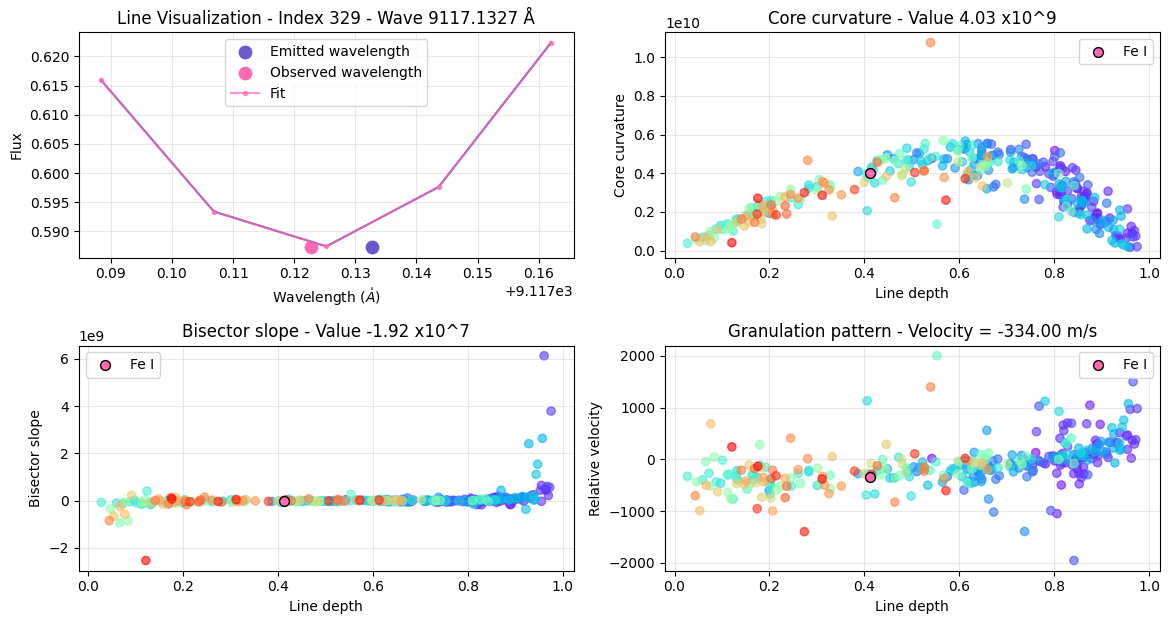

In [ ]:
# import tkinter as tk
# from tkinter import ttk
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
# import numpy as np

# class OutlierViewer:
#     def __init__(self, root, local_points, values, fit):
#         self.root = root
#         self.root.title("Visualizer of Fe I lines identification")
#         self.local_points = local_points
#         self.values = values
#         self.fit = fit
#         self.index = values.index.values
#         self.current_index = 0
       
#         self.setup_ui()
#         self.update_plot()
    
#     def setup_ui(self):
#         main_frame = ttk.Frame(self.root, padding="10")
#         main_frame.pack(fill=tk.BOTH, expand=True)
        
#         control_frame = ttk.Frame(main_frame)
#         control_frame.pack(fill=tk.X, pady=10)
        
#         ttk.Label(control_frame, text="Index of the line:").pack(side=tk.LEFT, padx=5)
#         self.slider = ttk.Scale(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             orient=tk.HORIZONTAL,
#             command=self.on_slider_move
#         )
#         self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
#         self.spinbox = ttk.Spinbox(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             width=5,
#             command=self.on_spinbox_change
#         )
#         self.spinbox.pack(side=tk.LEFT, padx=5)
#         self.spinbox.bind("<Return>", self.on_spinbox_change)
        
#         nav_frame = ttk.Frame(control_frame)
#         nav_frame.pack(side=tk.LEFT, padx=10)
        
#         ttk.Button(nav_frame, text="← Last", command=self.prev_plot).pack(side=tk.LEFT)
#         ttk.Button(nav_frame, text="Next →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
#         graph_frame = ttk.Frame(main_frame)
#         graph_frame.pack(fill=tk.BOTH, expand=True)
       
#         # Crear figura con dos subplots
#         self.fig, self.axs = plt.subplots(2, 2, figsize=(20, 14))
#         self.ax1, self.ax2,self.ax3, self.ax4 = self.axs.flat
#         self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
#         self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
#         self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
#         self.toolbar.update()
#         self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)
    
#     def on_slider_move(self, event=None):
#         self.current_index = int(float(self.slider.get()))
#         self.spinbox.delete(0, tk.END)
#         self.spinbox.insert(0, str(self.current_index))
#         self.update_plot()
    
#     def on_spinbox_change(self, event=None):
#         try:
#             new_index = int(self.spinbox.get())
#             if 0 <= new_index < len(self.index):
#                 self.current_index = new_index
#                 self.slider.set(self.current_index)
#                 self.update_plot()
#         except ValueError:
#             pass
    
#     def prev_plot(self):
#         if self.current_index > 0:
#             self.current_index -= 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     def next_plot(self):
#         if self.current_index < len(self.index)-1:
#             self.current_index += 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     def update_plot(self):
#         j = self.current_index
        
#         self.ax1.clear()
#         self.ax2.clear()
#         self.ax3.clear()
#         self.ax4.clear()
        
#         #Plot 1
#         # Fe I line
#         self.ax1.plot(self.local_points[j]['Wave'],
#                      self.local_points[j]['Flux'],
#                      c='slateblue')

#         self.ax1.scatter(
#             self.values['Emitted wavelength'].iloc[j],
#             self.values["Flux"].iloc[j],
#             color='slateblue',
#             s=80,
#             label='Emitted wavelength'
#         )

#         self.ax1.scatter(
#             self.values['Observed wavelength'].iloc[j],
#             self.values["Flux"].iloc[j],
#             color='hotpink',
#             s=80,
#             label='Observed wavelength'
#         )

#         # Fit
#         self.ax1.plot(self.local_points[j]['Wave'],
#                      self.fit[j],
#                      c='hotpink',
#                      marker='.',
#                      label='Fit',
#                      alpha=0.7)
        
#         self.ax1.set_title(f'Line Visualization - Index {self.index[j]} - Wave {self.values["Emitted wavelength"].iloc[j]} Å')
#         self.ax1.set_xlabel(r'Wavelength $(\mathring{A})$')
#         self.ax1.set_ylabel('Flux')
#         self.ax1.grid(True, alpha=0.3)
#         self.ax1.legend()
        
#          # Plot 2 - core curvature
#         self.ax2.scatter(1-self.values['Flux'],
#                         self.values['Core curvature'],
#                         c=self.values["Observed wavelength"],
#                         cmap='rainbow',lw=1,alpha=0.6)
        
#         #Fe I line
#         self.ax2.scatter(
#             1-self.values['Flux'].iloc[j],
#             self.values['Core curvature'].iloc[j],
#             color='hotpink',
#             label='Fe I',
#             s=50,edgecolor='black'
#         )
        
        
#         self.ax2.set_title(f'Core curvature - Value {self.values["Core curvature"].iloc[j]*1e-9:.2f} x10^9')
#         self.ax2.set_xlabel(r'Line depth')
#         self.ax2.set_ylabel('Core curvature')
#         self.ax2.grid(True, alpha=0.3)
#         self.ax2.legend()
        
#         # Plot 3 - bisector slope
#         self.ax3.scatter(1-self.values['Flux'],
#                         self.values['Bisector slope'],
#                         c=self.values["Observed wavelength"],
#                         cmap='rainbow',lw=1,alpha=0.6)
        
#         #Fe I line
#         self.ax3.scatter(
#             1-self.values['Flux'].iloc[j],
#             self.values['Bisector slope'].iloc[j],
#             color='hotpink',
#             label='Fe I',
#             s=50,
#             edgecolor='black'
#         )
        
        
#         self.ax3.set_title(f'Bisector slope - Value {self.values["Bisector slope"].iloc[j]*1e-7:.2f} x10^7')
#         self.ax3.set_xlabel(r'Line depth')
#         self.ax3.set_ylabel('Bisector slope')
#         self.ax3.grid(True, alpha=0.3)
#         self.ax3.legend()

#         # Plot 4 - granulation pattern
#         self.ax4.scatter(1-self.values['Flux'],
#                         self.values['Velocity'],
#                         c=self.values["Observed wavelength"],
#                         cmap='rainbow',lw=1,alpha=0.6)
#         # 
#         #Fe I line
#         self.ax4.scatter(
#             1-self.values['Flux'].iloc[j],
#             self.values['Velocity'].iloc[j],
#             color='hotpink',
#             label='Fe I',
#             s=50,
#             edgecolor='black'
#         )
        
        
#         self.ax4.set_title(f'Granulation pattern - Velocity = {self.values["Velocity"].iloc[j]:.2f} m/s')
#         self.ax4.set_xlabel(r'Line depth')
#         self.ax4.set_ylabel('Relative velocity')
#         self.ax4.grid(True, alpha=0.3)
#         self.ax4.legend()

#         self.fig.tight_layout()
        
#         self.canvas.draw()


# if __name__ == "__main__":
#     root = tk.Tk()
#     root.geometry("1200x700") 
    
#     app = OutlierViewer(root, local_points_r, Values_r, fit_r)
#     root.mainloop()

In [ ]:
# index_to_drop = [13, 48, 70, 73, 74, , 109, 185, 233, 304, 307, 324, 328]

# Values = Values.drop(index_to_drop).reset_index(drop=True)

# Values